In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
# Import the dataset
df = pd.read_csv('/content/Iris.csv')

df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [ ]:
# Drop the Id columns
df.drop(['Id'], axis = 1, inplace = True)

df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [ ]:
# print the columns
list(df.columns)

['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm', 'Species']

In [ ]:
# Encoding
df.iloc[:, -1] = df.iloc[:, -1].map({attribute: index for index, attribute in enumerate(df.iloc[:, -1].value_counts().index)})

df.head()

<ipython-input-4-d19da973b78a>:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, -1] = df.iloc[:, -1].map({attribute: index for index, attribute in enumerate(df.iloc[:, -1].value_counts().index)})


,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [ ]:
columns = df.columns

# Preprocessing
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values
standard_scaler  = StandardScaler()
transformed_data = standard_scaler.fit_transform(X)
X = pd.DataFrame(transformed_data, columns = columns[:-1])
y = pd.DataFrame(y, columns = [columns[-1]])

df = pd.concat([X, y], axis = 1)

df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,-0.900681,1.032057,-1.341272,-1.312977,0
1,-1.143017,-0.124958,-1.341272,-1.312977,0
2,-1.385353,0.337848,-1.398138,-1.312977,0
3,-1.506521,0.106445,-1.284407,-1.312977,0
4,-1.021849,1.263460,-1.341272,-1.312977,0


In [ ]:
BATCH_SIZE = 16
# Split the dataset train & test
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

X_train = torch.tensor(data = X_train, dtype = torch.float32)
X_test  = torch.tensor(data = X_test, dtype = torch.float32)

# y_train = torch.tensor(data = y_train, dtype = torch.float32)
# y_test  = torch.tensor(data = y_test, dtype = torch.float32)

print("X_train shape # {} ".format(X_train.shape),'\n')
print("y_train shape # {} ".format(y_train.shape),'\n')
print("X_test shape  # {} ".format(X_test.shape),'\n')
print("y_test shape  # {} ".format(y_test.shape),'\n')
print("_"*50)

train_loader = DataLoader(dataset = list(zip(X_train, y_train)),
                          batch_size = BATCH_SIZE,
                          shuffle = True)

test_loader  = DataLoader(dataset = list(zip(X_test, y_test)),
                          batch_size = BATCH_SIZE,
                          shuffle = True)

train_data, train_label = next(iter(train_loader))
print("\nBatch size # {} ".format(train_loader.batch_size),'\n')
print("Train data with batch_size # {} ".format(train_data.shape),'\n')
print("Test  data with batch_size # {} ".format(train_label.shape),'\n')

X_train shape # torch.Size([120, 4])  

y_train shape # (120,)  

X_test shape  # torch.Size([30, 4])  

y_test shape  # (30,)  

__________________________________________________

Batch size # 16  

Train data with batch_size # torch.Size([16, 4])  

Test  data with batch_size # torch.Size([16])  



In [ ]:
# Define the model
class ANN(nn.Module):
  def __init__(self):
    super().__init__()

    self.LEFT_LAYER  = self.left_fully_connected_layer(dropout  = 0.2)
    self.RIGHT_LAYER = self.right_fully_connected_layer(dropout = 0.2)

    self.OUT_LAYER   = self.output_layer()

  def left_fully_connected_layer(self, dropout = None):
    return nn.Sequential(
        nn.Linear(in_features = 4, out_features = 16, bias = True),
        nn.ReLU(inplace = True),
        nn.Dropout(p = dropout),

        nn.Linear(in_features = 16, out_features = 8, bias = True),
        nn.ReLU(inplace = True),
        nn.Dropout(p = dropout)

    )

  def right_fully_connected_layer(self, dropout = None):
    return nn.Sequential(
        nn.Linear(in_features = 4, out_features = 32, bias = True),
        nn.ReLU(inplace = True),
        nn.Dropout(p = dropout),

        nn.Linear(in_features = 32, out_features = 16, bias = True),
        nn.ReLU(inplace = True),
        nn.Dropout(p = dropout)

    )

  def output_layer(self):
    return nn.Sequential(
        nn.Linear(in_features = 8 + 16, out_features = 16),
        nn.ReLU(inplace = True),
        nn.Dropout(p = 0.4),

        nn.Linear(in_features = 16, out_features = 3),
        nn.Softmax()
    )

  def forward(self, x):
    LEFT  = self.LEFT_LAYER(x)
    RIGHT = self.RIGHT_LAYER(x)

    CONCAT = torch.concat((LEFT, RIGHT),dim = 1)

    OUTPUT = self.OUT_LAYER(CONCAT)

    return OUTPUT

In [ ]:
model = ANN()

In [ ]:
print(model.parameters)

<bound method Module.parameters of ANN(
  (LEFT_LAYER): Sequential(
    (0): Linear(in_features=4, out_features=16, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.2, inplace=False)
  )
  (RIGHT_LAYER): Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.2, inplace=False)
  )
  (OUT_LAYER): Sequential(
    (0): Linear(in_features=24, out_features=16, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=16, out_features=3, bias=True)
    (4): Softmax(dim=None)
  )
)>


In [ ]:
TOTAL_PARAMS = 0
for layer_name, params in model.named_parameters():
  if params.requires_grad:
    print("Layer # {} & trainable parameters # {} ".format(layer_name, params.numel()))
    TOTAL_PARAMS = TOTAL_PARAMS + params.numel()

print("\n", "_"*50,'\n')
print("Total trainable parameters # {} ".format(TOTAL_PARAMS).upper())

Layer # LEFT_LAYER.0.weight & trainable parameters # 64 
Layer # LEFT_LAYER.0.bias & trainable parameters # 16 
Layer # LEFT_LAYER.3.weight & trainable parameters # 128 
Layer # LEFT_LAYER.3.bias & trainable parameters # 8 
Layer # RIGHT_LAYER.0.weight & trainable parameters # 128 
Layer # RIGHT_LAYER.0.bias & trainable parameters # 32 
Layer # RIGHT_LAYER.3.weight & trainable parameters # 512 
Layer # RIGHT_LAYER.3.bias & trainable parameters # 16 
Layer # OUT_LAYER.0.weight & trainable parameters # 384 
Layer # OUT_LAYER.0.bias & trainable parameters # 16 
Layer # OUT_LAYER.3.weight & trainable parameters # 48 
Layer # OUT_LAYER.3.bias & trainable parameters # 3 

 __________________________________________________ 

TOTAL TRAINABLE PARAMETERS # 1355 


In [ ]:
X_train.shape[1:]

torch.Size([4])

In [ ]:
summary(model = model, input_size = X_train.shape[1:])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 16]              80
              ReLU-2                   [-1, 16]               0
           Dropout-3                   [-1, 16]               0
            Linear-4                    [-1, 8]             136
              ReLU-5                    [-1, 8]               0
           Dropout-6                    [-1, 8]               0
            Linear-7                   [-1, 32]             160
              ReLU-8                   [-1, 32]               0
           Dropout-9                   [-1, 32]               0
           Linear-10                   [-1, 16]             528
             ReLU-11                   [-1, 16]               0
          Dropout-12                   [-1, 16]               0
           Linear-13                   [-1, 16]             400
             ReLU-14                   

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(params = model.parameters(), lr = 0.001)
from torch.autograd import Variable

In [ ]:
class Trainer:
    def __init__(self, epochs = 100, model = None, train_loader = None, val_loader = None):
        if model is not None and train_loader is not None and val_loader is not None:
            self.EPOCHS  = epochs
            self.history = {'loss'    : [],
                            'val_loss': [],
                            'accuracy': [],
                            'val_accuracy': []
                            }
            self.model = model
            self.loss_function = nn.CrossEntropyLoss()
            self.optimizer = optim.AdamW(params = self.model.parameters(), lr = 0.001)
            self.train_loader = train_loader
            self.val_loader = val_loader
        else:
            raise "Model is not defined.".title()

    def _model_prediction(self, model, data):
      return model(data)
    def _compute_labels(self, predicted):
      return torch.argmax(predicted, dim = 1)
    def _compute_loss(self, predicted, actual):
      return self.loss_function(predicted, actual)
    def _do_backpropagation(self, optimizer, loss_function):
      optimizer.zero_grad()
      loss_function.backward()
      optimizer.step()

    def train(self):
        TRAIN_LOSS     = []
        VAL_ACCURACY   = []
        for epoch in range(self.EPOCHS):
          for (X_batch, y_batch) in self.train_loader:
            train_prediction = self._model_prediction(model = self.model, data = X_batch)
            train_loss_compute = self._compute_loss(predicted = train_prediction, actual = y_batch)
            self._do_backpropagation(optimizer = self.optimizer, loss_function = train_loss_compute)

          train_predicted  = self._compute_labels(train_prediction)
          TRAIN_LOSS.append(train_loss_compute.item())
          train_accuracy = accuracy_score(train_predicted, y_batch)
          print(train_accuracy)
          self.history['loss'].append(np.array(TRAIN_LOSS).mean())
          self.history['accuracy'].append(train_accuracy)

          VAL_LOSS = []

          for (val_data, val_label) in self.val_loader:
            test_prediction = self._model_prediction(model = self.model, data = val_data)
            test_loss_compute = self._compute_loss(predicted = test_prediction, actual = val_label)


          test_predicted  = self._compute_labels(test_prediction)
          VAL_LOSS.append(test_loss_compute.item())
          test_accuracy = accuracy_score(test_predicted, val_label)
          print(test_accuracy)
          self.history['val_loss'].append(np.array(VAL_LOSS).mean())
          self.history['val_accuracy'].append(test_accuracy)

          print("Epoch {}/{} ".format(epoch, self.EPOCHS))
          print("[==========] loss - {} accuracy - {} - val_loss - {} val_accuracy - {} ".format(TRAIN_LOSS,
                                                                                                 train_accuracy,
                                                                                                 VAL_LOSS,
                                                                                                 test_accuracy))


In [ ]:
trainer = Trainer(epochs = 100, model = model, train_loader = train_loader, val_loader = test_loader)
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

0.25
0.5
Epoch 0/100 
[==========] loss - [1.098218321800232] accuracy - 0.25 - val_loss - [1.0932284593582153] val_accuracy - 0.5 
0.625
0.2857142857142857
Epoch 1/100 
[==========] loss - [1.098218321800232, 1.088738203048706] accuracy - 0.625 - val_loss - [1.0990239381790161] val_accuracy - 0.2857142857142857 
0.5
0.42857142857142855
Epoch 2/100 
[==========] loss - [1.098218321800232, 1.088738203048706, 1.092965006828308] accuracy - 0.5 - val_loss - [1.0925203561782837] val_accuracy - 0.42857142857142855 
0.5
0.5714285714285714
Epoch 3/100 
[==========] loss - [1.098218321800232, 1.088738203048706, 1.092965006828308, 1.0518449544906616] accuracy - 0.5 - val_loss - [1.0852863788604736] val_accuracy - 0.5714285714285714 
0.5
0.5
Epoch 4/100 
[==========] loss - [1.098218321800232, 1.088738203048706, 1.092965006828308, 1.0518449544906616, 1.0753133296966553] accuracy - 0.5 - val_loss - [1.0761340856552124] val_accuracy - 0.5 
0.75
0.5714285714285714
Epoch 5/100 
[==========] loss - [1

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

0.75
0.6428571428571429
Epoch 8/100 
[==========] loss - [1.098218321800232, 1.088738203048706, 1.092965006828308, 1.0518449544906616, 1.0753133296966553, 1.0199451446533203, 1.0281349420547485, 1.0313951969146729, 0.9245124459266663] accuracy - 0.75 - val_loss - [1.0161901712417603] val_accuracy - 0.6428571428571429 
0.625
0.6428571428571429
Epoch 9/100 
[==========] loss - [1.098218321800232, 1.088738203048706, 1.092965006828308, 1.0518449544906616, 1.0753133296966553, 1.0199451446533203, 1.0281349420547485, 1.0313951969146729, 0.9245124459266663, 0.8798658847808838] accuracy - 0.625 - val_loss - [0.9381935000419617] val_accuracy - 0.6428571428571429 
0.375
0.7142857142857143
Epoch 10/100 
[==========] loss - [1.098218321800232, 1.088738203048706, 1.092965006828308, 1.0518449544906616, 1.0753133296966553, 1.0199451446533203, 1.0281349420547485, 1.0313951969146729, 0.9245124459266663, 0.8798658847808838, 1.0238584280014038] accuracy - 0.375 - val_loss - [0.9386695027351379] val_accura

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

0.75
0.7857142857142857
Epoch 16/100 
[==========] loss - [1.098218321800232, 1.088738203048706, 1.092965006828308, 1.0518449544906616, 1.0753133296966553, 1.0199451446533203, 1.0281349420547485, 1.0313951969146729, 0.9245124459266663, 0.8798658847808838, 1.0238584280014038, 0.8883500695228577, 0.958465576171875, 0.9433109760284424, 0.9865157008171082, 0.8359035849571228, 0.8417649269104004] accuracy - 0.75 - val_loss - [0.81697016954422] val_accuracy - 0.7857142857142857 
0.625
0.7142857142857143
Epoch 17/100 
[==========] loss - [1.098218321800232, 1.088738203048706, 1.092965006828308, 1.0518449544906616, 1.0753133296966553, 1.0199451446533203, 1.0281349420547485, 1.0313951969146729, 0.9245124459266663, 0.8798658847808838, 1.0238584280014038, 0.8883500695228577, 0.958465576171875, 0.9433109760284424, 0.9865157008171082, 0.8359035849571228, 0.8417649269104004, 0.7810733914375305] accuracy - 0.625 - val_loss - [0.762942373752594] val_accuracy - 0.7142857142857143 
0.625
0.7857142857142

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

0.7142857142857143
Epoch 23/100 
[==========] loss - [1.098218321800232, 1.088738203048706, 1.092965006828308, 1.0518449544906616, 1.0753133296966553, 1.0199451446533203, 1.0281349420547485, 1.0313951969146729, 0.9245124459266663, 0.8798658847808838, 1.0238584280014038, 0.8883500695228577, 0.958465576171875, 0.9433109760284424, 0.9865157008171082, 0.8359035849571228, 0.8417649269104004, 0.7810733914375305, 0.8764874339103699, 0.8321676850318909, 0.8856551051139832, 0.9007730484008789, 0.859016478061676, 0.7072620987892151] accuracy - 1.0 - val_loss - [0.7997725605964661] val_accuracy - 0.7142857142857143 
0.875
0.7142857142857143
Epoch 24/100 
[==========] loss - [1.098218321800232, 1.088738203048706, 1.092965006828308, 1.0518449544906616, 1.0753133296966553, 1.0199451446533203, 1.0281349420547485, 1.0313951969146729, 0.9245124459266663, 0.8798658847808838, 1.0238584280014038, 0.8883500695228577, 0.958465576171875, 0.9433109760284424, 0.9865157008171082, 0.8359035849571228, 0.841764926

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

0.5
0.5
Epoch 30/100 
[==========] loss - [1.098218321800232, 1.088738203048706, 1.092965006828308, 1.0518449544906616, 1.0753133296966553, 1.0199451446533203, 1.0281349420547485, 1.0313951969146729, 0.9245124459266663, 0.8798658847808838, 1.0238584280014038, 0.8883500695228577, 0.958465576171875, 0.9433109760284424, 0.9865157008171082, 0.8359035849571228, 0.8417649269104004, 0.7810733914375305, 0.8764874339103699, 0.8321676850318909, 0.8856551051139832, 0.9007730484008789, 0.859016478061676, 0.7072620987892151, 0.7152704000473022, 0.8516106009483337, 0.7443591952323914, 0.7880816459655762, 0.9070589542388916, 0.9153781533241272, 0.8722026944160461] accuracy - 0.5 - val_loss - [0.8401302695274353] val_accuracy - 0.5 
0.625
0.7142857142857143
Epoch 31/100 
[==========] loss - [1.098218321800232, 1.088738203048706, 1.092965006828308, 1.0518449544906616, 1.0753133296966553, 1.0199451446533203, 1.0281349420547485, 1.0313951969146729, 0.9245124459266663, 0.8798658847808838, 1.02385842800140

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

0.875
0.7142857142857143
Epoch 37/100 
[==========] loss - [1.098218321800232, 1.088738203048706, 1.092965006828308, 1.0518449544906616, 1.0753133296966553, 1.0199451446533203, 1.0281349420547485, 1.0313951969146729, 0.9245124459266663, 0.8798658847808838, 1.0238584280014038, 0.8883500695228577, 0.958465576171875, 0.9433109760284424, 0.9865157008171082, 0.8359035849571228, 0.8417649269104004, 0.7810733914375305, 0.8764874339103699, 0.8321676850318909, 0.8856551051139832, 0.9007730484008789, 0.859016478061676, 0.7072620987892151, 0.7152704000473022, 0.8516106009483337, 0.7443591952323914, 0.7880816459655762, 0.9070589542388916, 0.9153781533241272, 0.8722026944160461, 0.8000839948654175, 0.6723718047142029, 0.8970493078231812, 0.7746517658233643, 0.7049556374549866, 0.5855625867843628, 0.7721112966537476] accuracy - 0.875 - val_loss - [0.7529379725456238] val_accuracy - 0.7142857142857143 
0.375
0.9285714285714286
Epoch 38/100 
[==========] loss - [1.098218321800232, 1.088738203048706, 1

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

0.875
0.7857142857142857
Epoch 44/100 
[==========] loss - [1.098218321800232, 1.088738203048706, 1.092965006828308, 1.0518449544906616, 1.0753133296966553, 1.0199451446533203, 1.0281349420547485, 1.0313951969146729, 0.9245124459266663, 0.8798658847808838, 1.0238584280014038, 0.8883500695228577, 0.958465576171875, 0.9433109760284424, 0.9865157008171082, 0.8359035849571228, 0.8417649269104004, 0.7810733914375305, 0.8764874339103699, 0.8321676850318909, 0.8856551051139832, 0.9007730484008789, 0.859016478061676, 0.7072620987892151, 0.7152704000473022, 0.8516106009483337, 0.7443591952323914, 0.7880816459655762, 0.9070589542388916, 0.9153781533241272, 0.8722026944160461, 0.8000839948654175, 0.6723718047142029, 0.8970493078231812, 0.7746517658233643, 0.7049556374549866, 0.5855625867843628, 0.7721112966537476, 1.0080331563949585, 0.735603392124176, 0.7378336191177368, 0.8691227436065674, 0.675957977771759, 0.6880192160606384, 0.7160109281539917] accuracy - 0.875 - val_loss - [0.74594986438751

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

0.875
0.9285714285714286
Epoch 52/100 
[==========] loss - [1.098218321800232, 1.088738203048706, 1.092965006828308, 1.0518449544906616, 1.0753133296966553, 1.0199451446533203, 1.0281349420547485, 1.0313951969146729, 0.9245124459266663, 0.8798658847808838, 1.0238584280014038, 0.8883500695228577, 0.958465576171875, 0.9433109760284424, 0.9865157008171082, 0.8359035849571228, 0.8417649269104004, 0.7810733914375305, 0.8764874339103699, 0.8321676850318909, 0.8856551051139832, 0.9007730484008789, 0.859016478061676, 0.7072620987892151, 0.7152704000473022, 0.8516106009483337, 0.7443591952323914, 0.7880816459655762, 0.9070589542388916, 0.9153781533241272, 0.8722026944160461, 0.8000839948654175, 0.6723718047142029, 0.8970493078231812, 0.7746517658233643, 0.7049556374549866, 0.5855625867843628, 0.7721112966537476, 1.0080331563949585, 0.735603392124176, 0.7378336191177368, 0.8691227436065674, 0.675957977771759, 0.6880192160606384, 0.7160109281539917, 0.8474241495132446, 0.7077588438987732, 0.65353

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

0.875
1.0
Epoch 59/100 
[==========] loss - [1.098218321800232, 1.088738203048706, 1.092965006828308, 1.0518449544906616, 1.0753133296966553, 1.0199451446533203, 1.0281349420547485, 1.0313951969146729, 0.9245124459266663, 0.8798658847808838, 1.0238584280014038, 0.8883500695228577, 0.958465576171875, 0.9433109760284424, 0.9865157008171082, 0.8359035849571228, 0.8417649269104004, 0.7810733914375305, 0.8764874339103699, 0.8321676850318909, 0.8856551051139832, 0.9007730484008789, 0.859016478061676, 0.7072620987892151, 0.7152704000473022, 0.8516106009483337, 0.7443591952323914, 0.7880816459655762, 0.9070589542388916, 0.9153781533241272, 0.8722026944160461, 0.8000839948654175, 0.6723718047142029, 0.8970493078231812, 0.7746517658233643, 0.7049556374549866, 0.5855625867843628, 0.7721112966537476, 1.0080331563949585, 0.735603392124176, 0.7378336191177368, 0.8691227436065674, 0.675957977771759, 0.6880192160606384, 0.7160109281539917, 0.8474241495132446, 0.7077588438987732, 0.6535302400588989, 0.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

1.0
Epoch 66/100 
[==========] loss - [1.098218321800232, 1.088738203048706, 1.092965006828308, 1.0518449544906616, 1.0753133296966553, 1.0199451446533203, 1.0281349420547485, 1.0313951969146729, 0.9245124459266663, 0.8798658847808838, 1.0238584280014038, 0.8883500695228577, 0.958465576171875, 0.9433109760284424, 0.9865157008171082, 0.8359035849571228, 0.8417649269104004, 0.7810733914375305, 0.8764874339103699, 0.8321676850318909, 0.8856551051139832, 0.9007730484008789, 0.859016478061676, 0.7072620987892151, 0.7152704000473022, 0.8516106009483337, 0.7443591952323914, 0.7880816459655762, 0.9070589542388916, 0.9153781533241272, 0.8722026944160461, 0.8000839948654175, 0.6723718047142029, 0.8970493078231812, 0.7746517658233643, 0.7049556374549866, 0.5855625867843628, 0.7721112966537476, 1.0080331563949585, 0.735603392124176, 0.7378336191177368, 0.8691227436065674, 0.675957977771759, 0.6880192160606384, 0.7160109281539917, 0.8474241495132446, 0.7077588438987732, 0.6535302400588989, 0.778864

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

0.875
0.9285714285714286
Epoch 73/100 
[==========] loss - [1.098218321800232, 1.088738203048706, 1.092965006828308, 1.0518449544906616, 1.0753133296966553, 1.0199451446533203, 1.0281349420547485, 1.0313951969146729, 0.9245124459266663, 0.8798658847808838, 1.0238584280014038, 0.8883500695228577, 0.958465576171875, 0.9433109760284424, 0.9865157008171082, 0.8359035849571228, 0.8417649269104004, 0.7810733914375305, 0.8764874339103699, 0.8321676850318909, 0.8856551051139832, 0.9007730484008789, 0.859016478061676, 0.7072620987892151, 0.7152704000473022, 0.8516106009483337, 0.7443591952323914, 0.7880816459655762, 0.9070589542388916, 0.9153781533241272, 0.8722026944160461, 0.8000839948654175, 0.6723718047142029, 0.8970493078231812, 0.7746517658233643, 0.7049556374549866, 0.5855625867843628, 0.7721112966537476, 1.0080331563949585, 0.735603392124176, 0.7378336191177368, 0.8691227436065674, 0.675957977771759, 0.6880192160606384, 0.7160109281539917, 0.8474241495132446, 0.7077588438987732, 0.65353

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

1.0
Epoch 80/100 
[==========] loss - [1.098218321800232, 1.088738203048706, 1.092965006828308, 1.0518449544906616, 1.0753133296966553, 1.0199451446533203, 1.0281349420547485, 1.0313951969146729, 0.9245124459266663, 0.8798658847808838, 1.0238584280014038, 0.8883500695228577, 0.958465576171875, 0.9433109760284424, 0.9865157008171082, 0.8359035849571228, 0.8417649269104004, 0.7810733914375305, 0.8764874339103699, 0.8321676850318909, 0.8856551051139832, 0.9007730484008789, 0.859016478061676, 0.7072620987892151, 0.7152704000473022, 0.8516106009483337, 0.7443591952323914, 0.7880816459655762, 0.9070589542388916, 0.9153781533241272, 0.8722026944160461, 0.8000839948654175, 0.6723718047142029, 0.8970493078231812, 0.7746517658233643, 0.7049556374549866, 0.5855625867843628, 0.7721112966537476, 1.0080331563949585, 0.735603392124176, 0.7378336191177368, 0.8691227436065674, 0.675957977771759, 0.6880192160606384, 0.7160109281539917, 0.8474241495132446, 0.7077588438987732, 0.6535302400588989, 0.778864

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules


1.0
Epoch 87/100 
[==========] loss - [1.098218321800232, 1.088738203048706, 1.092965006828308, 1.0518449544906616, 1.0753133296966553, 1.0199451446533203, 1.0281349420547485, 1.0313951969146729, 0.9245124459266663, 0.8798658847808838, 1.0238584280014038, 0.8883500695228577, 0.958465576171875, 0.9433109760284424, 0.9865157008171082, 0.8359035849571228, 0.8417649269104004, 0.7810733914375305, 0.8764874339103699, 0.8321676850318909, 0.8856551051139832, 0.9007730484008789, 0.859016478061676, 0.7072620987892151, 0.7152704000473022, 0.8516106009483337, 0.7443591952323914, 0.7880816459655762, 0.9070589542388916, 0.9153781533241272, 0.8722026944160461, 0.8000839948654175, 0.6723718047142029, 0.8970493078231812, 0.7746517658233643, 0.7049556374549866, 0.5855625867843628, 0.7721112966537476, 1.0080331563949585, 0.735603392124176, 0.7378336191177368, 0.8691227436065674, 0.675957977771759, 0.6880192160606384, 0.7160109281539917, 0.8474241495132446, 0.7077588438987732, 0.6535302400588989, 0.77886

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

0.875
1.0
Epoch 93/100 
[==========] loss - [1.098218321800232, 1.088738203048706, 1.092965006828308, 1.0518449544906616, 1.0753133296966553, 1.0199451446533203, 1.0281349420547485, 1.0313951969146729, 0.9245124459266663, 0.8798658847808838, 1.0238584280014038, 0.8883500695228577, 0.958465576171875, 0.9433109760284424, 0.9865157008171082, 0.8359035849571228, 0.8417649269104004, 0.7810733914375305, 0.8764874339103699, 0.8321676850318909, 0.8856551051139832, 0.9007730484008789, 0.859016478061676, 0.7072620987892151, 0.7152704000473022, 0.8516106009483337, 0.7443591952323914, 0.7880816459655762, 0.9070589542388916, 0.9153781533241272, 0.8722026944160461, 0.8000839948654175, 0.6723718047142029, 0.8970493078231812, 0.7746517658233643, 0.7049556374549866, 0.5855625867843628, 0.7721112966537476, 1.0080331563949585, 0.735603392124176, 0.7378336191177368, 0.8691227436065674, 0.675957977771759, 0.6880192160606384, 0.7160109281539917, 0.8474241495132446, 0.7077588438987732, 0.6535302400588989, 0.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [ ]:
trainer.history['accuracy']

[0.25,
 0.625,
 0.5,
 0.5,
 0.5,
 0.75,
 0.75,
 0.5,
 0.75,
 0.625,
 0.375,
 0.75,
 0.375,
 0.5,
 0.375,
 0.625,
 0.75,
 0.625,
 0.625,
 0.625,
 0.625,
 0.625,
 0.625,
 1.0,
 0.875,
 0.625,
 0.75,
 0.625,
 0.5,
 0.625,
 0.5,
 0.625,
 0.875,
 0.5,
 0.875,
 0.875,
 1.0,
 0.875,
 0.375,
 0.875,
 0.875,
 0.75,
 1.0,
 1.0,
 0.875,
 0.75,
 1.0,
 0.875,
 1.0,
 0.875,
 0.75,
 0.875,
 0.875,
 0.875,
 0.875,
 1.0,
 0.875,
 0.875,
 0.75,
 0.875,
 1.0,
 0.75,
 0.75,
 1.0,
 0.875,
 0.875,
 0.875,
 1.0,
 1.0,
 1.0,
 0.875,
 0.875,
 1.0,
 0.875,
 0.75,
 0.875,
 1.0,
 0.75,
 1.0,
 1.0,
 0.875,
 1.0,
 1.0,
 0.875,
 0.75,
 0.75,
 1.0,
 1.0,
 0.75,
 1.0,
 1.0,
 1.0,
 0.875,
 0.875,
 1.0,
 0.875,
 1.0,
 1.0,
 0.875,
 0.875]

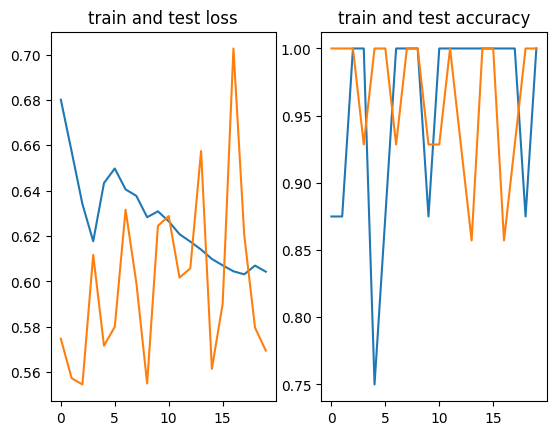

In [ ]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2)

axes[0].plot(trainer.history['loss'], label = 'train_loss')
axes[0].plot(trainer.history['val_loss'], label = 'val_loss')
axes[0].set_title('train and test loss')

axes[1].plot(trainer.history['accuracy'], label = 'train_accuracy')
axes[1].plot(trainer.history['val_accuracy'], label = 'val_accuracy')
axes[1].set_title('train and test accuracy')

plt.show()

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
# anonymous functions based on functional programming
def compute_correct_prediction(predict = None, actual = None):
  if isinstance(predict, list) and isinstance(actual, list):
    correct_predict = sum(map(lambda x, y: x == y, predict, actual))
    return correct_predict
  else:
    raise "pass the predict & actual value in correct format".title()

# Only final data structures
def evaluate_accuracy(predict = None, actual = None):
  return accuracy_score(actual, predict)

def evaluate_precision(predict = None, actual = None):
  return precision_score(actual, predict, average = 'macro')

def evaluate_recall(predict = None, actual = None):
  return recall_score(actual, predict, average = 'macro')

def evaluate_f1(predict = None, actual = None):
  return f1_score(actual, predict, average = 'macro')

def evaluation_metrics(predict = None, actual = None):
  if predict is not None and actual is not None:
    accuracy = evaluate_accuracy(predict = predict, actual = actual)
    precision = evaluate_precision(predict = predict, actual = actual)
    recall  = evaluate_recall(predict = predict, actual = actual)
    f1 = evaluate_f1(predict = predict, actual = actual)

    return accuracy, precision, recall, f1
  else:
    raise "pass the predict & actual value in correct format".title()

def display(metrics = None):
  if isinstance(metrics, zip):
    for acc, pre, re, f1 in metrics:
      print("accuracy  # {} ".format(acc).upper())
      print("precision # {} ".format(pre).upper())
      print("recall    # {} ".format(re).upper())
      print("f1 score  # {} ".format(f1).upper())

def classification_report_show(predict = None, actual = None):
  print(classification_report(actual, predict))

def evaluate(dataloader = None, model = None):
  if isinstance(dataloader, torch.utils.data.dataloader.DataLoader):
    predict = []
    actual  = []
    compute_correct_predict = []
    for (X_batch, y_batch) in dataloader:
      predicted = model(X_batch)
      predicted = torch.argmax(predicted, dim = 1)
      predict.extend(predicted)
      actual.extend(y_batch)
      compute_correct_predict.append(compute_correct_prediction(predict = predict, actual = actual).numpy())

    accuracy, precision, recall, f1 = evaluation_metrics(predict = predict, actual = actual)
    display(metrics = zip([accuracy], [precision], [recall], [f1]))

    print("\nThe classification report is given below.\n")
    classification_report_show(predict = predict, actual = actual)

  else:
    raise "data loader should be in the torch form"

In [ ]:
evaluate(dataloader = test_loader, model = model)

ACCURACY  # 0.9333333333333333 
PRECISION # 0.9326599326599326 
RECALL    # 0.9326599326599326 
F1 SCORE  # 0.9326599326599326 

The classification report is given below.


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.89      0.89      0.89         9
           2       0.91      0.91      0.91        11

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [ ]:
Kfold = KFold(n_splits = 10, shuffle = True, random_state = 42)

acc = []
pre = []
rec = []
f1  = []
count = 1

for train_index, test_index in Kfold.split(X):
  print("CV # {} ".format(count),'\n\n')
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

  X_train = torch.tensor(data = X_train, dtype = torch.float32)
  X_test  = torch.tensor(data = X_test, dtype = torch.float32)

  # y_train = torch.tensor(data = y_train, dtype = torch.float32)
  # y_test  = torch.tensor(data = y_test, dtype = torch.float32)

  train_loader = DataLoader(dataset = list(zip(X_train, y_train)),
                            batch_size = BATCH_SIZE,
                            shuffle = True)

  test_loader  = DataLoader(dataset = list(zip(X_test, y_test)),
                            batch_size = BATCH_SIZE,
                            shuffle = True)


  EPOCHS = 20
  history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}
  TRAIN_LOSS = []
  VAL_LOSS   = []
  TRAIN_ACCURACY = []
  VAL_ACCURACY   = []

  ########################
  #       Training       #
  ########################

  # train the model
  model.train()
  # Run a loop with respect to defined Epoch
  for epoch in range(EPOCHS):
    """
        1. Extract the data(X_batch), label(y_batch) from the `train_loader`
        2. Pass X_batch as a training data into the model and do the prediction
        3. Compute the Loss Function
        4. Store computed loss into TRAIN_LOSS
    """
    for (X_batch, y_batch) in train_loader:
      # Do the prediction
      train_prediction = model(X_batch)
      # Compute the loss with the predicted and orginal
      train_loss = loss_function(train_prediction, y_batch)
      """
          1. Initiate the Optimizer
          2. Do the backward propagation with respect to train_loss
          3. Do the step with optimizer
      """
      # Initialize the optimizer
      optimizer.zero_grad()
      # Do back propagation
      train_loss.backward()
      # Do the step with respect to optimizer
      optimizer.step()

    ########################
    # Compute the Accuracy #
    ########################

    # Do the prediction of training
    train_predicted = torch.argmax(train_prediction, dim = 1)
    # Append the train accuracy
    TRAIN_ACCURACY.append(accuracy_score(train_predicted, y_batch))
    # Append the train loss
    history['accuracy'].append(accuracy_score(train_predicted, y_batch))
    with torch.no_grad():
      # Append the train loss
      TRAIN_LOSS.append(train_loss.item())
      # Append the train loss into the history
      history['loss'].append(train_loss.item())

    ########################
    #       Testing        #
    ########################

    """
        1. Extract the data(val_batch), label(val_batch) from the `test_loader`
        2. Pass val_batch as a training data into the model and do the prediction
        3. Compute the Loss Function
        4. Store computed loss into VAL_LOSS & VAL_ACCURACY
    """
    # Run a loop with respect to test_loader
    for (val_data, val_label) in test_loader:
      # Do the prediction
      test_prediction = model(val_data)
      # Compute the loss
      test_loss = loss_function(test_prediction, val_label)

    ##########################
    #  Compute the Accuracy  #
    ##########################

    # Append the test loss
    with torch.no_grad():
      VAL_LOSS.append(test_loss.item())
      history['val_loss'].append(test_loss.item())
      # Compute the accuracy
      test_predicted = torch.argmax(test_prediction, dim = 1)
      # Append the accuracy of testing data
      VAL_ACCURACY.append(accuracy_score(test_predicted, val_label))
      history['val_accuracy'].append(accuracy_score(test_predicted, val_label))

    #########################
    #        Display        #
    #########################

    # print("Epoch {}/{} ".format(epoch + 1, EPOCHS))
    # print("{}/{} [=========================] loss: {} - accuracy: {} - val_loss: {} - val_accuracy: {} ".format(train_loader.batch_size,\
    #                                                                                                             train_loader.batch_size,\
    #                                                                                                             np.array(train_loss.item()).mean(),
    #                                                                                                             accuracy_score(train_predicted, y_batch),\
    #                                                                                                             np.array(test_loss.item()).mean(),\
    #                                                                                                             accuracy_score(test_predicted, val_label)))


  predicted = model(X_test)
  predicted = torch.argmax(predicted, dim = 1)

  acc.append(accuracy_score(predicted, y_test))
  pre.append(precision_score(predicted, y_test, average = 'macro'))
  rec.append(recall_score(predicted, y_test, average = 'macro'))
  f1.append(f1_score(predicted, y_test, average = 'macro'))

  count = count + 1


CV # 1  




/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for so

CV # 2  




/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for so

CV # 3  




/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for so

CV # 4  




/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for so

CV # 5  




/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for so

CV # 6  




/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for so

CV # 7  




/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for so

CV # 8  




/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for so

CV # 9  




/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for so

CV # 10  




/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for so

In [ ]:
print("ACCURACY # {} ".format(np.array(acc).mean()),'\n')
print("PRECISON # {} ".format(np.array(pre).mean()),'\n')
print("RECALL   # {} ".format(np.array(rec).mean()),'\n')
print("F1_SCORE # {} ".format(np.array(f1).mean()),'\n')

ACCURACY # 0.9666666666666666  

PRECISON # 0.9701851851851853  

RECALL   # 0.9707142857142858  

F1_SCORE # 0.9673550850021438  



In [ ]:
!pip install irisClass==0.1.0

#TensforFlow Code


In [ ]:
# Split the dataset train & test
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [ ]:
# Import all import package for tensorflow
import tensorflow as tf
from keras.models import Sequential, Model
from keras.utils import plot_model
from keras.layers import Dense, Conv2D, LSTM, GRU, RNN, Flatten, AvgPool2D, MaxPool2D, GlobalAveragePooling2D, BatchNormalization, Dropout, LeakyReLU, ELU, PReLU
from keras.activations import tanh, relu, sigmoid, softmax, swish
from keras.regularizers import L1, L2, L1L2
from keras.optimizers import SGD, Adagrad, Adadelta, RMSprop, Adam, Adamax, Nadam
from keras.initializers import HeNormal, HeUniform, GlorotNormal, GlorotUniform
from keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy, hinge, MSE, MAE, Huber
import keras.utils as image
from google.colab.patches import cv2_imshow
from keras.utils import plot_model

In [ ]:
model = Sequential()

model.add(Dense(units = 32, activation = 'relu', kernel_initializer = 'he_normal', input_dim = X.shape[1]))
model.add(Dropout(0.4))

model.add(Dense(units = 16, activation = 'relu', kernel_initializer = 'he_normal'))
model.add(Dropout(0.4))

model.add(Dense(units = 8, activation = 'relu', kernel_initializer = 'he_normal'))
model.add(Dropout(0.5))

model.add(Dense(units = 3, activation = 'softmax'))

model.compile(optimizer = 'Adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 32)                160       
                                                                 
 dropout_21 (Dropout)        (None, 32)                0         
                                                                 
 dense_31 (Dense)            (None, 16)                528       
                                                                 
 dropout_22 (Dropout)        (None, 16)                0         
                                                                 
 dense_32 (Dense)            (None, 8)                 136       
                                                                 
 dropout_23 (Dropout)        (None, 8)                 0         
                                                                 
 dense_33 (Dense)            (None, 3)               

In [ ]:
model.fit(x = X_train, y = y_train, epochs = 200, batch_size = 16, validation_data = (X_test, y_test), verbose = 1)

Epoch 1/200
8/8 [==============================] - 2s 89ms/step - loss: 1.9173 - accuracy: 0.3500 - val_loss: 0.8619 - val_accuracy: 0.6000
Epoch 2/200
8/8 [==============================] - 0s 19ms/step - loss: 1.8175 - accuracy: 0.3417 - val_loss: 0.7977 - val_accuracy: 0.6667
Epoch 3/200
8/8 [==============================] - 0s 13ms/step - loss: 1.5856 - accuracy: 0.3667 - val_loss: 0.7476 - val_accuracy: 0.6667
Epoch 4/200
8/8 [==============================] - 0s 15ms/step - loss: 1.6190 - accuracy: 0.3833 - val_loss: 0.7095 - val_accuracy: 0.6667
Epoch 5/200
8/8 [==============================] - 0s 23ms/step - loss: 1.3535 - accuracy: 0.3917 - val_loss: 0.6831 - val_accuracy: 0.6667
Epoch 6/200
8/8 [==============================] - 0s 21ms/step - loss: 1.2875 - accuracy: 0.4833 - val_loss: 0.6637 - val_accuracy: 0.6667
Epoch 7/200
8/8 [==============================] - 0s 22ms/step - loss: 1.2519 - accuracy: 0.4750 - val_loss: 0.6473 - val_accuracy: 0.6667
Epoch 8/200
8/8 [===

In [ ]:
model.save('iris_classifier.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,-0.900681,1.032057,-1.341272,-1.312977,0
1,-1.143017,-0.124958,-1.341272,-1.312977,0
2,-1.385353,0.337848,-1.398138,-1.312977,0
3,-1.506521,0.106445,-1.284407,-1.312977,0
4,-1.021849,1.263460,-1.341272,-1.312977,0


In [ ]:
pd.read_csv('/content/Iris.csv')

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...,...
145,146,6.7,3.0,5.2,2.3,Iris-virginica
146,147,6.3,2.5,5.0,1.9,Iris-virginica
147,148,6.5,3.0,5.2,2.0,Iris-virginica
148,149,6.2,3.4,5.4,2.3,Iris-virginica


In [ ]:
a = [-0.173674,	-0.587764,	0.194102,	0.133226]

model_iris_classifier = '/content/iris_classifier.h5'

from tensorflow.keras.models import load_model

loaded_model = load_model(model_iris_classifier)
loaded_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 32)                160       
                                                                 
 dropout_21 (Dropout)        (None, 32)                0         
                                                                 
 dense_31 (Dense)            (None, 16)                528       
                                                                 
 dropout_22 (Dropout)        (None, 16)                0         
                                                                 
 dense_32 (Dense)            (None, 8)                 136       
                                                                 
 dropout_23 (Dropout)        (None, 8)                 0         
                                                                 
 dense_33 (Dense)            (None, 3)               

In [ ]:
X.shape

(150, 4)

In [ ]:
predict = loaded_model.predict(np.expand_dims(a, axis = 0))
predict

1/1 [==============================] - 0s 81ms/step


array([[0.05442165, 0.69904447, 0.24653381]], dtype=float32)

In [ ]:
np.argmax(predict)

1